In [1]:
import requests
from datetime import date, timedelta
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 9]

csv_url = 'https://brasil.io/api/dataset/covid19/caso/data?format=json&place_type=state'
data = requests.get(csv_url).json()['results']

In [2]:
states = set(p['state'] for p in data)
fd = {s:[(date.fromisoformat(p['date']), p['confirmed']) for p in data if p['state']== s] for s in states}

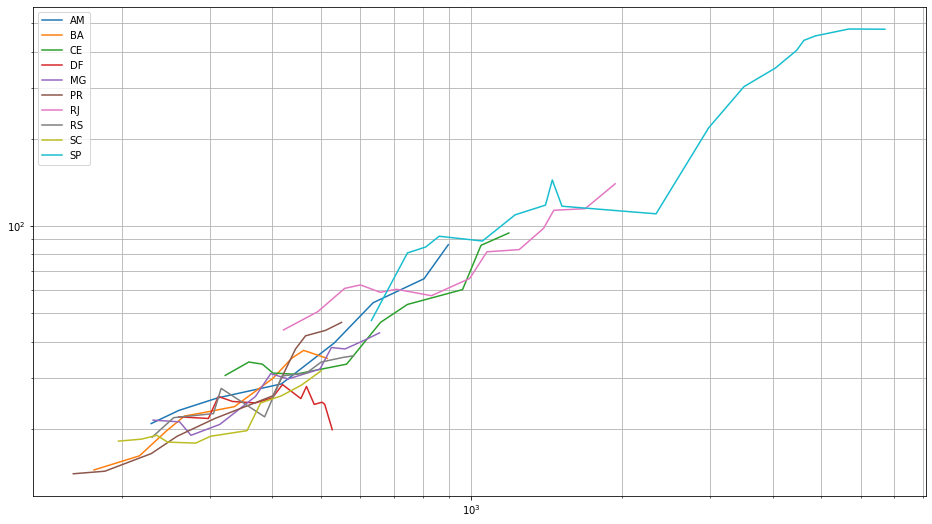

In [9]:
def gap_fill(data: list):
    for p in range((data[-1][0] - data[0][0]).days):
        if data[p+1][0] - data[p][0] > timedelta(days=1):
            data.insert(p+1, (data[p][0]+timedelta(days=1), data[p][1]))
for _, v in fd.items():
    v.sort(key=lambda x: x[0])
    gap_fill(v)
    
MA_DAYS = 7
MIN_CASES = 50
    
days = set(d[0] for d in fd['SP'])
    
casos = {s: np.array([d[1] for d in fd[s] if d[1]>=MIN_CASES]) for s in states}
fdict = {
    s: {p[0]: p[1] for p in fd[s]}
    for s in states
}
brasil_casos = np.array([sum(fdict[s].get(day,0) for s in states) for day in days])
brasil_casos = np.array([n for n in brasil_casos if n>10])
brasil_casos.sort()
brasil_novos = brasil_casos[1:] - brasil_casos[:-1]
brasil_ma = [np.average(brasil_novos[k:k+MA_DAYS]) for k in range(len(brasil_novos)-MA_DAYS)]
novos_casos = {s: casos[s][1:] - casos[s][:-1] for s in states}
novos_casos_ma = {
    s: 
        [np.average(novos_casos[s][k:k+MA_DAYS]) for k in range(len(novos_casos[s])-MA_DAYS)]
    
    for s in states
    }
fig,ax = plt.subplots()
dados_plot = {s: ax.loglog(casos[s][MA_DAYS+1:], novos_casos_ma[s], label=s) for s in sorted(states) if len(novos_casos_ma[s])>5}
# brasil_plot = ax.loglog(brasil_casos[MA_DAYS+1:], brasil_ma, label='Brasil')
l = ax.legend()
ax.grid(which='both')